## Notebook to run the simulations for DeepSea

In [ ]:
import numpy as np
import pandas as pd
from utils.dataset import Dataset
from itertools import product
from scipy.stats import bootstrap
from tabulate import tabulate
from scipy.stats import t as tstudent
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
num_steps = [(20, 50000), (30,100000)]
num_seeds = 30
agents = ['APT', 'RND', 'DBMR-BPI', 'Disagreement Agent']
seeds = [x for x in range(num_seeds)]
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

dfs = {}

for size, num_step in num_steps:
    path = 'data/DeepSea/{}_{}/'.format(size, num_step)
    data = []
    for seed, agent in product(seeds, agents):
        dataset = Dataset.load(f'{path}/{agent}_{seed}.pkl.lzma')
        buffer = dataset.buffer
        rewards = buffer._data[2]
        terminals = buffer._data[3]
        num_rewards = dataset.env_config.num_rewards
        steps = np.arange(rewards.shape[0])
        episodes = np.cumsum(terminals)
        
        res = {f'reward_{i}': rewards[:,i] for i in range(num_rewards)}
        res['episodes']= episodes
        res['seed'] = seed
        res['agent'] = agent
        
        df = pd.DataFrame(res)
        
        data.append(df)
    dfs[(size, num_step)] = pd.concat(data)


In [2]:

TITLE_SIZE = 16
LEGEND_SIZE = 13
TICK_SIZE = 13
AXIS_TITLE = 16
AXIS_LABEL = 13
FONT_SIZE = 13


rc_parameters = {
    "font.size": FONT_SIZE,
    "axes.titlesize": AXIS_TITLE,
    "axes.labelsize": AXIS_LABEL,
    "xtick.labelsize": TICK_SIZE,
    "ytick.labelsize": TICK_SIZE,
    "legend.fontsize": LEGEND_SIZE,
    "figure.titlesize": TITLE_SIZE,
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": r'\usepackage{amsmath}\usepackage{mathtools} \usepackage{amssymb}'
}
plt.rcParams.update(rc_parameters)
plt.rcParams["text.latex.preamble"].join([
        r"\usepackage{amsmath}",              
        r"\usepackage{mathtools}",
        r"\usepackage{amssymb}"
])

colors = {
    'Disagreement Agent': '#f8766d',
    'DBMR-BPI': '#00bfc4',
    'RND': 'mediumorchid',
    'APT': '#3B3B3B'
}

labels_agents = {
    'Disagreement Agent': r'Disagreement',
    'DBMR-BPI': r'DBMR-BPI',
    'RND': r'RND',
    'APT': r'APT'
}
ordered_agents = ['DBMR-BPI', 'RND',  'Disagreement Agent', 'APT']
sns.set_style("darkgrid", rc=rc_parameters)

In [3]:
df_grouped = {}
df_numpy = {}
for size, num_step in num_steps:
    df_grouped[(size, num_step)]= dfs[(size, num_step)].groupby(['agent','seed','episodes']).sum().groupby(['agent', 'seed']).mean()


    dim1 = len(df_grouped[(size, num_step)].index.get_level_values(0).unique())
    dim2 = len(df_grouped[(size, num_step)].index.get_level_values(1).unique())
    df_numpy[(size, num_step)] = df_grouped[(size, num_step)].to_numpy().reshape((dim1, dim2, df_grouped[(size, num_step)].shape[1]))

In [4]:

round = lambda x: np.round(x, decimals=1)
res_values = []
res_dict = {}

def isclose(x, axis):
    return np.isclose(x, 0).sum(axis)

for size, num_step in num_steps:
    res_dict[size] = {}
    df_x = df_numpy[(size, num_step)]
    base_rewards = df_x[..., :size]
    rnd_rewards = df_x[..., size:]

    
    for type_rew, rewards_set in [('Base', base_rewards), ('Random', rnd_rewards)]:
        res_dict[size][type_rew] = {}
        
        for func_name, func in [('GAvg', stats.mstats.gmean),  ('Avg', np.mean), ('Max', np.max), ('Min', np.min), ('Median', lambda x,axis: np.median(x, axis=axis)), ('STD', np.std), ('isclose', isclose)]:
            res_dict[size][type_rew][func_name] = {}
            rew_set_func =  func(rewards_set, axis=-1)#sfunc(rewards_set, axis=-1)

            rew_set_func_avg = rew_set_func.mean(-1)
            rew_set_func_ci = bootstrap((rew_set_func,), np.mean, axis=1, method='percentile').confidence_interval
            

            
            for idx, agent in enumerate(df_grouped[(size, num_step)].index.get_level_values(0).unique()):
                
                c = 100 if func_name != 'isclose'  else 1
                res_dict[size][type_rew][func_name][agent] = f'{round(rew_set_func_avg[idx] * c)}({round(rew_set_func_ci.low[idx] * c)},{round(rew_set_func_ci.high[idx] * c)})'
                res_values.append([size, type_rew, agent, func_name, 
                                   res_dict[size][type_rew][func_name][agent]
                                ])
print(tabulate(res_values))

--  ------  ------------------  -------  ---------------
20  Base    APT                 GAvg     1.4(0.8,1.9)
20  Base    DBMR-BPI            GAvg     4.6(4.6,4.6)
20  Base    Disagreement Agent  GAvg     0.0(0.0,0.0)
20  Base    MR-BSP              GAvg     4.5(4.5,4.5)
20  Base    RND                 GAvg     4.6(4.2,4.7)
20  Base    APT                 Avg      5.0(5.0,5.0)
20  Base    DBMR-BPI            Avg      5.0(5.0,5.0)
20  Base    Disagreement Agent  Avg      5.0(5.0,5.0)
20  Base    MR-BSP              Avg      5.0(5.0,5.0)
20  Base    RND                 Avg      5.0(5.0,5.0)
20  Base    APT                 Max      19.7(17.7,21.9)
20  Base    DBMR-BPI            Max      7.9(7.8,8.0)
20  Base    Disagreement Agent  Max      20.4(18.7,22.2)
20  Base    MR-BSP              Max      7.3(7.2,7.4)
20  Base    RND                 Max      8.9(8.5,9.2)
20  Base    APT                 Min      0.2(0.1,0.2)
20  Base    DBMR-BPI            Min      1.7(1.6,1.8)
20  Base    Disagre

In [7]:
df_grouped = {}
df_numpy = {}
for size, num_step in num_steps:
    df_grouped[(size, num_step)]= dfs[(size, num_step)].groupby(['agent','seed','episodes']).sum().groupby(['agent', 'seed']).cumsum()


    dim1 = len(df_grouped[(size, num_step)].index.get_level_values(0).unique())
    dim2 = len(df_grouped[(size, num_step)].index.get_level_values(1).unique())
    dim3 = len(df_grouped[(size, num_step)].index.get_level_values(2).unique())
    df_numpy[(size, num_step)] = df_grouped[(size, num_step)].to_numpy().reshape((dim1, dim2, dim3, df_grouped[(size, num_step)].shape[-1]))

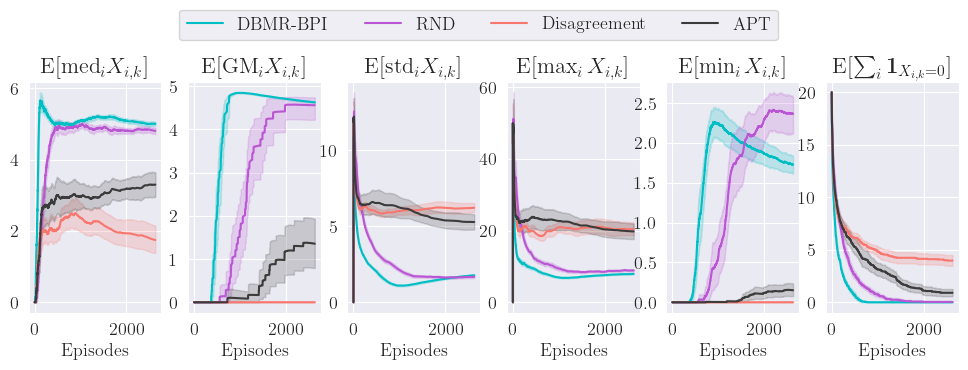

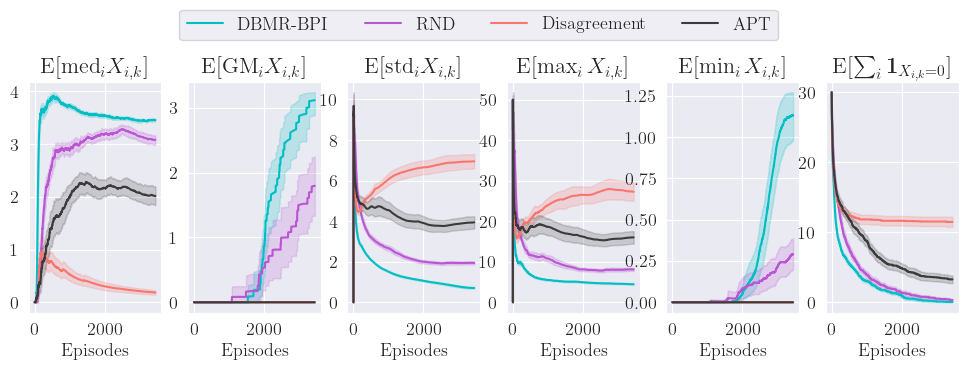

In [10]:
sns.set_style("darkgrid", rc=rc_parameters)
def CE(x, c=0.95):
    N = x.shape[0]
    alpha = c + (1-c)/2
    c = tstudent.ppf(alpha, N)
    s = np.std(x, axis=0, ddof=1)
    return x.mean(0), c * s/ np.sqrt(N)

functions= [('Median', lambda x,axis: np.median(x, axis=axis)), ('GAvg', stats.mstats.gmean),  ('STD', np.std), ('Max', np.max), ('Min', np.min),  ('isclose', isclose)]
for size, num_step in num_steps:
    fig, ax = plt.subplots(1, 6, figsize=(12,3))
    agents_ids = {
        agent: agent_id for agent_id, agent in enumerate(df_grouped[(size, num_step)].index.get_level_values(0).unique())
    }
    for agent in ordered_agents:
        agent_id = agents_ids[agent]
        if agent == 'MR-BSP': continue
        for axid, (func_name, func) in enumerate(functions):
            T = 1+np.array(df_grouped[(size, num_step)].index.get_level_values(2).unique()) if func_name != 'isclose' else np.array([1])
            plot_data = func(df_numpy[(size, num_step)][agent_id][...,:size]/T[None,:, None], axis=-1)#.max(-1)#.mean(0)
            plot_data_mu = plot_data.mean(0)

            mu = plot_data_mu
            plot_data_ci = bootstrap((plot_data,), np.mean, axis=0, method='percentile').confidence_interval
            ce_low, ce_high = plot_data_ci.low, plot_data_ci.high
            
            mu = mu if func_name == 'isclose' else mu * 100
            ce_low = ce_low if func_name == 'isclose' else ce_low * 100
            ce_high = ce_high if func_name == 'isclose' else ce_high * 100
            ax[axid].plot(mu, label=labels_agents[agent], color=colors[agent])
            ax[axid].fill_between(np.arange(plot_data.shape[1]), ce_low,ce_high, alpha=0.2,color=colors[agent])


            if func_name == 'Max':
                ax[axid].set_title(r'$\mathrm{E}[\max_i X_{i,k}]$')
            elif func_name == 'Min':
                ax[axid].set_title(r'${\rm E}[\min_i X_{i,k}]$')
            elif func_name == 'STD':
                ax[axid].set_title(r'${\rm E}[{\rm std}_i X_{i,k}]$')
            elif func_name == 'Median':
                ax[axid].set_title(r'${\rm E}[{\rm med}_i X_{i,k}]$')
            elif func_name == 'isclose':
                ax[axid].set_title(r'${\rm E}[\sum_{i} \mathbf{1}_{X_{i,k} = 0}]$')
            elif func_name == 'GAvg':
                ax[axid].set_title(r'${\rm E}[{\rm GM}_i X_{i,k}]$')
            ax[axid].set_xlabel('Episodes')
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), frameon=True, ncols=4)
    plt.savefig(f'figures/DeepSea/base_rew_size_{size}.pdf', bbox_inches='tight')
    plt.show()

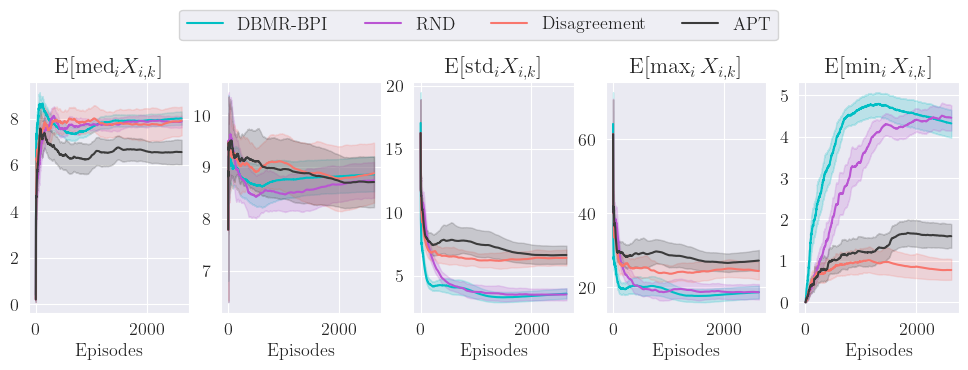

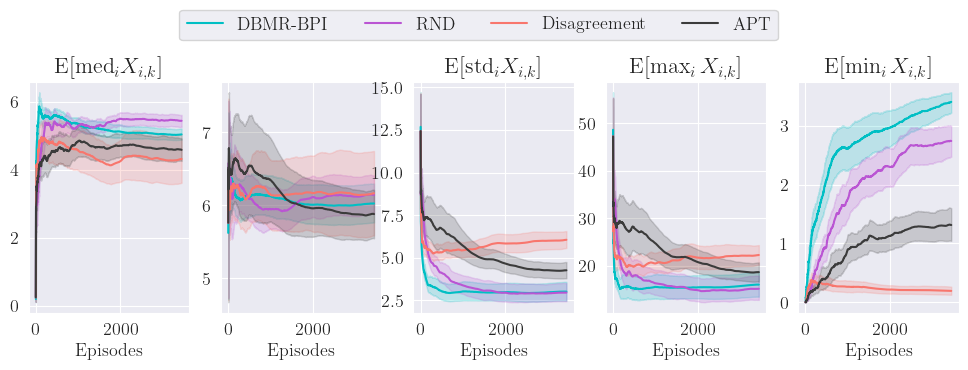

In [11]:
sns.set_style("darkgrid", rc=rc_parameters)

functions= [('Median', lambda x,axis: np.median(x, axis=axis)), ('Avg', np.mean),  ('STD', np.std), ('Max', np.max), ('Min', np.min)]

for size, num_step in num_steps:
    fig, ax = plt.subplots(1, 5, figsize=(12,3))
    agents_ids = {
        agent: agent_id for agent_id, agent in enumerate(df_grouped[(size, num_step)].index.get_level_values(0).unique())
    }
    for agent in ordered_agents:
        agent_id = agents_ids[agent]
        if agent == 'MR-BSP': continue
        for axid, (func_name, func) in enumerate(functions):
            T = 1+np.array(df_grouped[(size, num_step)].index.get_level_values(2).unique()) if func_name != 'isclose' else np.array([1])
            plot_data = func(df_numpy[(size, num_step)][agent_id][...,size:]/T[None,:, None], axis=-1)#.max(-1)#.mean(0)
            plot_data_mu = plot_data.mean(0)

            mu = plot_data_mu
            plot_data_ci = bootstrap((plot_data,), np.mean, axis=0, method='percentile').confidence_interval
            ce_low, ce_high = plot_data_ci.low, plot_data_ci.high
            
            mu = mu if func_name == 'isclose' else mu * 100
            ce_low = ce_low if func_name == 'isclose' else ce_low * 100
            ce_high = ce_high if func_name == 'isclose' else ce_high * 100
            ax[axid].plot(mu, label=labels_agents[agent], color=colors[agent])
            ax[axid].fill_between(np.arange(plot_data.shape[1]), ce_low,ce_high, alpha=0.2,color=colors[agent])


            if func_name == 'Max':
                ax[axid].set_title(r'$\mathrm{E}[\max_i X_{i,k}]$')
            elif func_name == 'Min':
                ax[axid].set_title(r'${\rm E}[\min_i X_{i,k}]$')
            elif func_name == 'STD':
                ax[axid].set_title(r'${\rm E}[{\rm std}_i X_{i,k}]$')
            elif func_name == 'Median':
                ax[axid].set_title(r'${\rm E}[{\rm med}_i X_{i,k}]$')
            elif func_name == 'isclose':
                ax[axid].set_title(r'${\rm E}[\sum_{i} \mathbf{1}_{X_{i,k} = 0}]$')
            elif func_name == 'GAvg':
                ax[axid].set_title(r'${\rm E}[{\rm GM}_i X_{i,k}]$')

            ax[axid].set_xlabel('Episodes')
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), frameon=True, ncols=4)
    plt.savefig(f'figures/DeepSea/rnd_rew_size_{size}.pdf', bbox_inches='tight')
    plt.show()

In [12]:
import lzma
import pickle
from typing import NamedTuple
num_steps = [(20,50000), (30, 100000)]
num_seeds = 30
seeds = [x for x in range(num_seeds)]
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

dfs = {}


for size, num_step in num_steps:
    path = 'data/DeepSea/{}_{}/'.format(size, num_step)
    data = []
    history_chosen_rewards = []
    history_delta_min = []
    min_size = np.infty
    for seed in seeds:
        with lzma.open(f'{path}/DBMR-BPI_{seed}_info.pkl.lzma', 'rb') as f:
            data_info = pickle.load(f)

        history_chosen_rewards.append(np.array(data_info['history_chosen_rewards']))
        history_delta_min.append(data_info['history_delta_min'])
        min_size = min(min_size, len(history_chosen_rewards[-1]))

  

    history_chosen_rewards = [x[:min_size] for x in history_chosen_rewards]

    dfs[(size, num_step)] = {'history_chosen_rewards': np.array(history_chosen_rewards),
                             'history_delta_min': np.array(history_delta_min)}

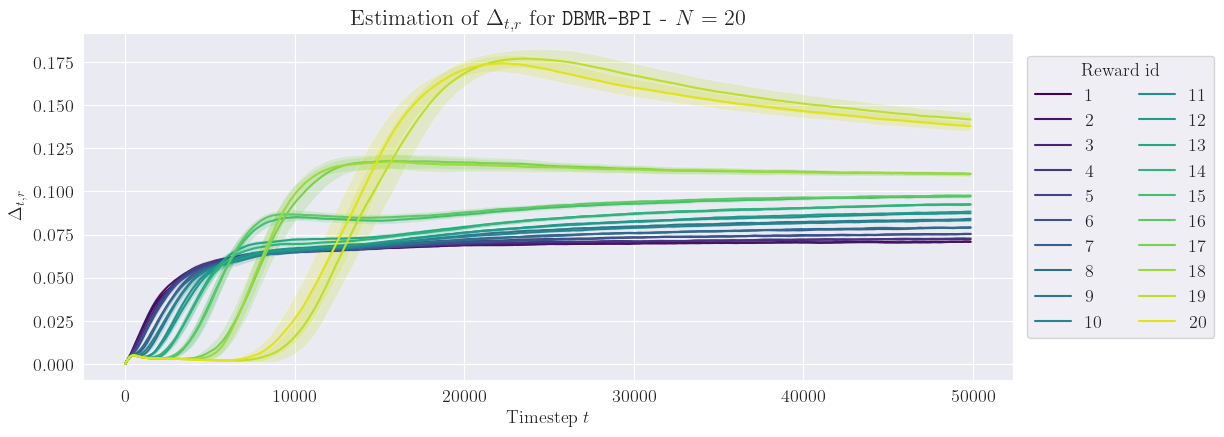

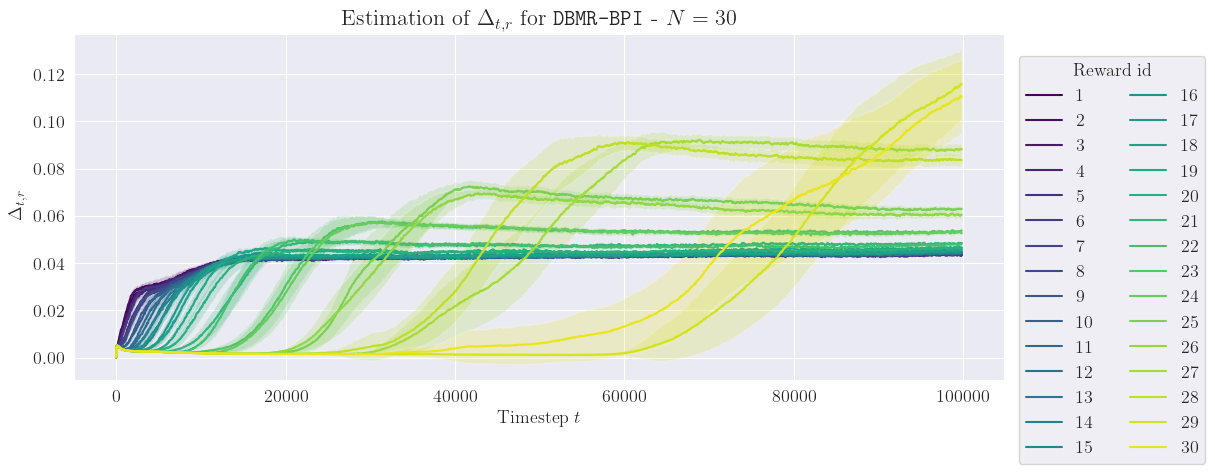

In [31]:

cm = plt.get_cmap('viridis')
                 
def downsample(data, factor):
    return data[::factor]        


factor= {20: 20, 30: 50}
for size, num_step in num_steps:
    NUM_COLORS = size


    x = dfs[(size, num_step)]
    xmean = x['history_delta_min'].mean(0)

    xmean, xce = CE(x['history_delta_min'])


    fig, ax = plt.subplots(1,1, figsize=(12,4.5))
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    for i in range(size):
        xval = downsample(xmean[:,i], factor[size])
        xrange = downsample(np.arange(xmean[:,i].shape[0]), factor[size])
        xvalce = downsample(xce[:,i], factor[size])

        ax.plot(xrange,xval, label=f'{i+1}')
        
        ax.fill_between(xrange, xval-xvalce, xval+xvalce, alpha=0.2)
    plt.xlabel(r'Timestep $t$')
    plt.ylabel(r'$\Delta_{t,r}$')
    plt.title(r'Estimation of $\Delta_{t,r}$ for {\tt DBMR-BPI}' + f' - $N={size}$')
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(.99, 0.85), frameon=True, ncols=2, title='Reward id')
    plt.savefig(f'figures/DeepSea/delta_min_{size}.pdf', bbox_inches='tight')
    plt.show()

     

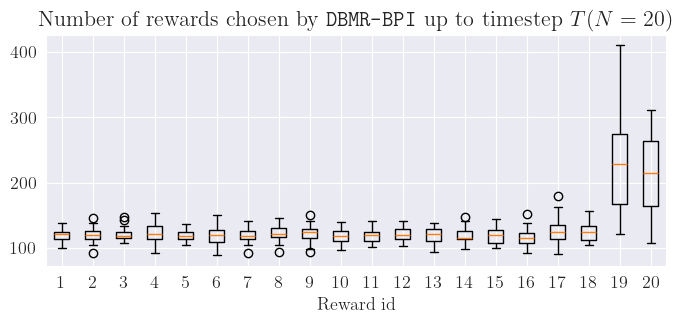

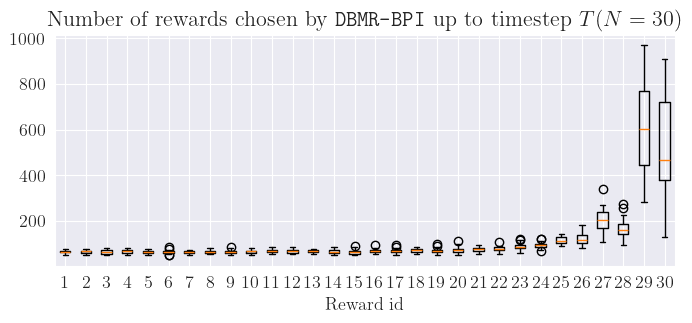

In [26]:
for size, num_step in num_steps:
    x = dfs[(size, num_step)]
    Xnew = np.eye(size)[x['history_chosen_rewards']]
    Xnew = Xnew.cumsum(axis=1)
    fig, ax = plt.subplots(1,1, figsize=(8,3))

    ax.boxplot(Xnew[:,-1])
    ax.set_xlabel('Reward id')
    ax.set_title(r'Number of rewards chosen by {\tt DBMR-BPI} up to timestep $T$' + f'($N={size}$)')
    plt.savefig(f'figures/DeepSea/num_rew_chosen_{size}.pdf', bbox_inches='tight')
    plt.show()
